In [1]:
import numpy as np
from scipy.optimize import minimize
from itertools import product
import warnings

# ---------------------------
# Helper functions
# ---------------------------
def default_gaussian_kernel(x, y, length_scale=0.2, variance=1.0):
    """
    Gaussian (squared exponential) kernel.
    
    Args:
        x (np.array): first input vector.
        y (np.array): second input vector.
        length_scale (float): kernel length-scale.
        variance (float): kernel variance.
        
    Returns:
        float: kernel value.
    """
    x = np.array(x)
    y = np.array(y)
    sqdist = np.sum((x - y) ** 2)
    return variance * np.exp(-0.5 * sqdist / (length_scale ** 2))


def create_uniform_grid(bounds, num_points_per_dim=10):
    """
    Creates a uniform grid (as a list of candidate points) over the domain.
    
    Args:
        bounds (list of tuples): list of (low, high) bounds for each dimension.
        num_points_per_dim (int): number of grid points per dimension.
        
    Returns:
        List[np.array]: list of candidate points.
    """
    grids = [np.linspace(b[0], b[1], num_points_per_dim) for b in bounds]
    grid_points = list(product(*grids))
    return [np.array(point) for point in grid_points]


# ---------------------------
# POPBO Class
# ---------------------------
class POPBO:
    """
    Principled Optimistic Preferential Bayesian Optimization (POP-BO)
    
    This class implements the full algorithm:
      1. Initialize with an initial point.
      2. For each iteration t:
         a. Set reference point as the previous candidate.
         b. Select a new candidate point by approximately maximizing 
            the optimistic advantage (i.e. f(x) - f(x_ref)).
         c. Query the oracle with the pair (candidate, reference) to 
            get a binary outcome.
         d. Update the maximum likelihood estimator (MLE) of the surrogate
            function based on the duel data.
      3. Report the best estimated solution.
      
    Note: All points where the function is “evaluated” (i.e. when the
    surrogate value f(x) is computed) are marked as "FUNC_EVAL POINT".
    """
    def __init__(self, config):
        """
        Initialize the POP-BO optimizer.
        
        Config parameters (with defaults):
         - x_dim: input dimension (default: 1)
         - bounds: list of (low, high) tuples for each dimension (default: [(0,1)]*x_dim)
         - kernel: a function that accepts (x, y) and returns a scalar value; 
                   default is the Gaussian kernel with length_scale=0.2.
         - kernel_params: dict for kernel parameters (e.g., {'length_scale':0.2, 'variance':1.0})
         - beta: a function of t (iteration index) used in confidence adjustment (default: lambda t: 0.1*np.sqrt(t+1))
         - oracle: a function oracle(x1, x2) that returns a binary outcome.
         - x0: initial point (np.array) to start the algorithm.
         - grid: a list of candidate points to use for candidate selection;
                   if not provided, a uniform grid over the domain is created.
         - reg: regularization weight for likelihood estimation (default: 1e-3)
         - B: bound for f(x) (default: 1.0) so that f(x) ∈ [-B, B]
         - num_grid: number of grid points per dimension if grid not provided (default: 10)
         - max_iter_estimator: maximum iterations for the MLE optimizer (default: 100)
         - epsilon: numerical stability constant (default: 1e-6)
        """
        self.x_dim = config.get('x_dim', 1)
        self.bounds = config.get('bounds', [(0, 1)] * self.x_dim)
        self.kernel_params = config.get('kernel_params', {'length_scale': 0.2, 'variance': 1.0})
        self.kernel = config.get('kernel', default_gaussian_kernel)
        self.beta = config.get('beta', lambda t: 0.1 * np.sqrt(t + 1))
        # The oracle function: expects signature oracle(x1, x2) -> {0,1}
        if 'oracle' not in config or not callable(config['oracle']):
            raise ValueError("A valid oracle function must be provided in config under 'oracle'.")
        self.oracle = config['oracle']
        
        self.x0 = config.get('x0')
        if self.x0 is None:
            raise ValueError("Initial point x0 must be provided in config.")
        self.x0 = np.array(self.x0)

        self.grid = config.get('grid', create_uniform_grid(self.bounds, config.get('num_grid', 10)))
        self.reg = config.get('reg', 1e-3)
        self.B = config.get('B', 1.0)
        self.max_iter_estimator = config.get('max_iter_estimator', 100)
        self.epsilon = config.get('epsilon', 1e-6)

        # Data structures for storing duel data and unique points.
        # duels: list of tuples (index_candidate, index_reference, outcome)
        self.duels = []
        # data_points: list of unique points encountered (np.array)
        self.data_points = []
        # mapping: point key -> index in data_points
        self.point_index = {}
        
        # Initialize with initial point (both candidate and reference for first duel)
        self._add_point(self.x0)
        self.x_history = [self.x0]       # List of candidate points chosen (x_t)
        self.x_ref_history = [self.x0]     # Reference points (x'_t), initially x0
        self.outcomes = []               # Oracle outcomes (1 or 0) for each duel
        
        # Maximum likelihood estimator function (f_hat) is initially a zero function.
        self.current_estimator = lambda x: 0.0

    # --- Utility Methods ---
    def _point_to_key(self, x):
        """Helper method to convert an np.array point to a tuple key."""
        return tuple(np.round(x, decimals=8))
    
    def _add_point(self, x):
        """
        Add point x to the unique data_points list if not already present.
        
        Returns:
            index of x in self.data_points.
        """
        key = self._point_to_key(x)
        if key not in self.point_index:
            self.point_index[key] = len(self.data_points)
            self.data_points.append(np.array(x))
        return self.point_index[key]
    
    # --- Main POP-BO Algorithm Methods ---
    def select_candidate(self, x_ref, f_hat):
        """
        Select a new candidate point x by approximately maximizing 
        the optimistic advantage f(x) - f(x_ref) over the domain X.
        
        For simplicity, we use a grid search over self.grid.
        FUNC_EVAL POINT: The surrogate f_hat is evaluated at each candidate.
        
        Args:
            x_ref (np.array): The reference point (x'_t)
            f_hat (callable): The current surrogate function.
            
        Returns:
            np.array: The chosen candidate point.
        """
        best_val = -np.inf
        best_x = None
        # Evaluate f_hat on each candidate in the grid.
        for x in self.grid:
            val = f_hat(x) - f_hat(x_ref)
            if val > best_val:
                best_val = val
                best_x = x
        return np.array(best_x)
    
    def update_estimator(self):
        """
        Update the maximum likelihood estimator f_hat from duel data.
        
        We formulate the following optimization problem:
        
           maximize   L(f) = sum_{duels} [ outcome * f(i) + (1-outcome)*f(j)
                      - log(exp(f(i)) + exp(f(j)) ) ]
           subject to f_i ∈ [-B, B] for each data point i,
                      plus an L2 regularization term (reg/2)*||f||^2.
        
        Here, f is a vector of function values at all unique data points
        in self.data_points.
        
        The optimal f is then used (via kernel interpolation) to create a surrogate
        function for prediction.
        
        FUNC_EVAL POINT: The surrogate f_hat is updated for all points in the dataset.
        """
        # Only update if we have at least one duel.
        if len(self.duels) == 0:
            return

        N = len(self.data_points)
        # Kernel matrix K over the data points.
        X = np.array(self.data_points)  # shape: (N, x_dim)
        K = np.zeros((N, N))
        for i in range(N):
            for j in range(N):
                # Using provided kernel and parameters.
                K[i, j] = self.kernel(X[i], X[j], 
                                      length_scale=self.kernel_params.get('length_scale', 0.2),
                                      variance=self.kernel_params.get('variance', 1.0))
        # Regularize K for inversion later.
        K += self.epsilon * np.eye(N)

        def neg_log_likelihood(f_vec):
            L = 0.0
            for (i, j, outcome) in self.duels:
                diff = f_vec[i] - f_vec[j]
                sig = 1 / (1 + np.exp(-diff))
                p = outcome * sig + (1 - outcome) * (1 - sig)
                # Add small epsilon to avoid log(0)
                L += np.log(p + 1e-9)
            reg_term = 0.5 * self.reg * np.sum(f_vec ** 2)
            return -L + reg_term


        def grad_neg_log_likelihood(f_vec):
            grad = np.zeros_like(f_vec)
            for (i, j, outcome) in self.duels:
                diff = f_vec[i] - f_vec[j]
                sig = 1 / (1 + np.exp(-diff))
                # Derivative of the likelihood wrt f_i and f_j
                dL_df = (outcome - sig)
                grad[i] -= dL_df
                grad[j] += dL_df
            grad += self.reg * f_vec
            return grad


    # Initial guess: use current estimator values at data points (or zeros)
        init_f = np.zeros(N)
        # Optionally, we can warm-start with previous f values if available.
        
        # Set bounds: each f_i in [-B, B]
        bounds_f = [(-self.B, self.B)] * N
        
        # Use L-BFGS-B for optimization.
        res = minimize(neg_log_likelihood, init_f, jac=grad_neg_log_likelihood,
                       bounds=bounds_f, method='L-BFGS-B', options={'maxiter': self.max_iter_estimator})
        if not res.success:
            warnings.warn("Estimator update did not converge: " + res.message)
        
        f_opt = res.x  # Optimal function values at the data points
        
        # Compute alpha = K^{-1} f_opt for kernel interpolation.
        alpha = np.linalg.solve(K, f_opt)
        
        # Define the surrogate estimator f_hat as a function:
        def f_hat(x):
            # FUNC_EVAL POINT: surrogate prediction for new x.
            x = np.array(x)
            k_vec = np.array([self.kernel(x, X[i],
                                          length_scale=self.kernel_params.get('length_scale', 0.2),
                                          variance=self.kernel_params.get('variance', 1.0)) for i in range(N)])
            return float(np.dot(k_vec, alpha))
        
        self.current_estimator = f_hat

    def report_best_solution(self):
        """
        Report the best candidate point.
        
        In this simple version, we return the candidate from the history
        that has the maximum estimated surrogate value f_hat.
        
        Returns:
            np.array: the reported best solution.
        """
        best_val = -np.inf
        best_point = None
        for x in self.x_history:
            val = self.current_estimator(x)  # FUNC_EVAL POINT
            if val > best_val:
                best_val = val
                best_point = x
        return best_point

    def run(self, T=10):
        """
        Run the POP-BO algorithm for T iterations.
        
        Each iteration performs:
          - Set reference point as the previous candidate.
          - Select new candidate (via maximizing surrogate advantage).
          - Query the oracle.
          - Update the MLE estimator based on duel data.
          
        After T iterations, return the final reported best solution.
        
        Args:
            T (int): number of iterations.
            
        Returns:
            np.array: final best solution.
        """
        for t in range(1, T + 1):
            # Step 3: Set reference point x'_t = last candidate.
            x_ref = self.x_history[-1]
            self.x_ref_history.append(x_ref)
            
            # Step 4: Select a new candidate by maximizing f(x) - f(x_ref).
            candidate = self.select_candidate(x_ref, self.current_estimator)
            self.x_history.append(candidate)
            
            # Step 5: Query the oracle with (candidate, reference).
            # (This is the oracle step that you can later replace with your own "black box" algorithm.)
            outcome = self.oracle(candidate, x_ref)
            self.outcomes.append(outcome)
            
            # Store duel data.
            i_candidate = self._add_point(candidate)
            i_ref = self._add_point(x_ref)
            self.duels.append((i_candidate, i_ref, outcome))
            
            # Highlight: these are the points where we "evaluate" the surrogate.
            # (For debugging or experimental logging, you might record candidate and x_ref evaluations.)
            print(f"Iteration {t}: Candidate = {candidate}, Reference = {x_ref}, Outcome = {outcome}")
            
            # Step 6: Update the estimator using all duel data.
            self.update_estimator()
        
        # Finally, report the best solution found.
        best_sol = self.report_best_solution()
        print("Final reported best solution:", best_sol)
        return best_sol

In [33]:
# ---------------------------
# Minimal Working Example
# ---------------------------
if __name__ == "__main__":
    # Define a dummy oracle. In practice you would replace this with your own black-box oracle.
    # Here we simulate a true objective function f_true (unknown to the optimizer).
    def f_true(x):
        # FUNC_EVAL POINT: This is the true objective function (unknown to the POPBO algorithm).
        # For illustration, let f_true be a multi-dimensional quadratic function with maximum at 0.8
        x = np.array(x)
        if x.ndim != 1:
            return -np.sum((x - 0.8) ** 2, axis=1)
        else:
            return -np.sum((x - 0.8) ** 2)
    
    def oracle(x1, x2, det=True):
        """
        Compare two candidate points.
        Return 1 if x1 is preferred to x2, else 0.
        The probability of preferring x1 is given by the Bradley-Terry model:
           P(x1 preferred) = exp(f_true(x1)) / (exp(f_true(x1)) + exp(f_true(x2))).
        """
        p = np.exp(f_true(x1)) / (np.exp(f_true(x1)) + np.exp(f_true(x2)))
        if det:
            observation = p > 0.5
        else:
            observation = p > np.random.uniform()
        # For a deterministic outcome (for testing), choose 1 if p > 0.5.
        return observation
    
    # Configuration for POPBO.
    config = {
        'x_dim': 2,                               # 2D problem
        'bounds': [(0, 1), (0, 1)],                # default domain is [0,1]^2
        'kernel_params': {'length_scale': 0.1, 'variance': 1.0},
        'kernel': default_gaussian_kernel,         # use default Gaussian kernel
        'beta': lambda t: 0.1 * np.sqrt(t + 1),      # beta function (not used explicitly in this simplified version)
        'oracle': oracle,                          # our dummy oracle function
        'x0': np.array([0.7, 0.7]),                  # initial point in the middle of [0,1]^2
        'num_grid': 20,                            # use 20 points per dimension in the grid
        'reg': 1e-2,
        'B': 1.0,
        'max_iter_estimator': 100,
        'epsilon': 1e-6
    }
    
    # Initialize and run POPBO for a fixed number of iterations.
    popbo = POPBO(config)
    final_solution = popbo.run(T=3)
    
    print("Final solution (as estimated by POPBO):", final_solution)
    print("Function value (as estimated by POPBO):", popbo.current_estimator(final_solution))
    print("True function value at final solution (unknown to algorithm):", f_true(final_solution))


Iteration 1: Candidate = [0. 0.], Reference = [0.7 0.7], Outcome = False
Iteration 2: Candidate = [0.68421053 0.68421053], Reference = [0. 0.], Outcome = True
Iteration 3: Candidate = [0.68421053 0.68421053], Reference = [0.68421053 0.68421053], Outcome = False
Final reported best solution: [0.7 0.7]
Final solution (as estimated by POPBO): [0.7 0.7]
Function value (as estimated by POPBO): 0.9999994937678921
True function value at final solution (unknown to algorithm): -0.020000000000000035


In [34]:
import matplotlib.pyplot as plt
X = np.linspace(0, 1, 100)
Y = np.linspace(0, 1, 100)
X, Y = np.meshgrid(X, Y)
grid = np.stack([m.flatten() for m in (X, Y)]).T
function_plot = f_true(grid).reshape(X.shape)
estimated_grid = list()
for grid_elem in grid:
    estimated_grid.append(popbo.current_estimator(grid_elem))
estimated_grid = np.array(estimated_grid).reshape(X.shape)

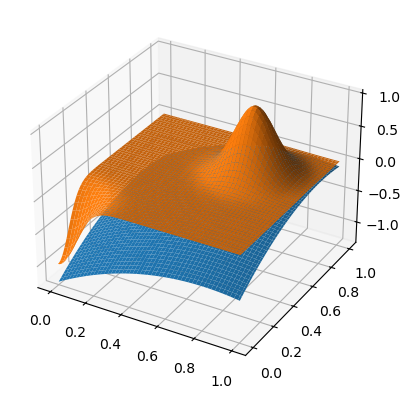

In [35]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
#ax.set_zlim(-2, 2)
surf = ax.plot_surface(X, Y, function_plot)
surf2 = ax.plot_surface(X, Y, estimated_grid)

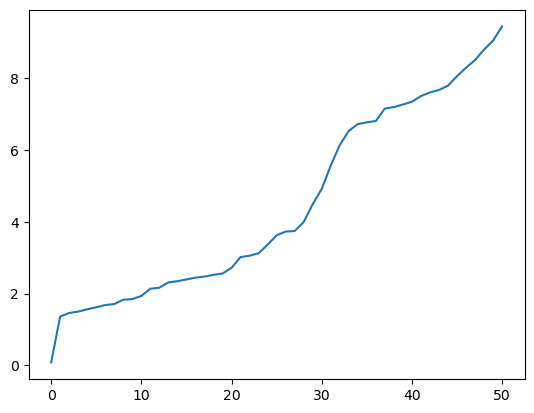

In [23]:
x_hist = np.array(popbo.x_history)
vals_found = f_true(x_hist)
plt.plot(-(vals_found.cumsum()))